In [1]:
import tensorflow as tf
from six.moves import cPickle as pickle
import matplotlib.pyplot as plt
import numpy as np
import math

%matplotlib inline

In [2]:
pickle_image_file = 'images.pickle'
pickle_label_file = 'labels.pickle'
pickle_lengths_file = 'lengths.pickle'

def extract_pickle(pickle_file):
    with open(pickle_file, 'rb') as f:
        save = pickle.load(f)
        return save
    
images = extract_pickle(pickle_image_file)
labels = extract_pickle(pickle_label_file)
lengths = extract_pickle(pickle_lengths_file)

In [3]:
train_dataset = np.array(images[:16001])
train_labels = np.array(labels[:16001])
train_lengths = np.array(lengths[:16001])
valid_dataset = np.array(images[16001 : 17001])
valid_labels = np.array(labels[16001 : 17001])
valid_lengths = np.array(lengths[16001 : 17001])
test_dataset = np.array(images[17001 : ])
test_labels = np.array(labels[17001 : ])
test_lengths = np.array(lengths[17001 : ])

[[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  1.]
 [ 0.  0.  0.  0.  0.  0.  1.  0.  0.  0.]
 [ 1.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]]
[ 0.  0.  0.  1.  0.]


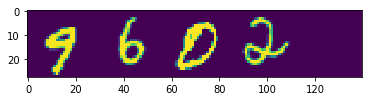

In [4]:
plt.imshow(images[12291])
print(train_labels[12291])
print(train_lengths[12291])

In [5]:
image_size_row = 28
image_size_col = 140
num_channels = 1 # grayscale

# Reformat images.
def reformat(dataset):
    dataset = dataset.reshape(
        (-1, image_size_row, image_size_col, num_channels)).astype(np.float32)
    return dataset

train_dataset = reformat(train_dataset)
valid_dataset = reformat(valid_dataset)
test_dataset = reformat(test_dataset)
print('Training set', train_dataset.shape, train_labels.shape, train_lengths.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape, valid_lengths.shape)
print('Test set', test_dataset.shape, test_labels.shape, test_lengths.shape)

Training set (16001, 28, 140, 1) (16001, 5, 10) (16001, 5)
Validation set (1000, 28, 140, 1) (1000, 5, 10) (1000, 5)
Test set (1331, 28, 140, 1) (1331, 5, 10) (1331, 5)


In [6]:
''' To be edited '''
''' Naive version '''
def accuracy(predictions, labels):
    output = []
    for i in range(5):
        output.append([])
        for label in labels:
            output[len(output)-1].append(np.argmax(label[i]))
        output[len(output)-1] = np.array(output[len(output)-1])
    
    output1 = [np.argmax(prediction, 1) for prediction in predictions]
    
    count = 0
    for i in range(5):
        for j in range(16):
            if(output[i][j] == output1[i][j]):
                count += 1
                
    return count / 80 * 100


In [12]:
batch_size = 16
patch_size = 5
depth = 14
num_possible_lengths = 5 # for training lengths
num_possible_digits = 10 # for training digits

graph = tf.Graph()

with graph.as_default():
    
    # Input data
    tf_train_dataset = tf.placeholder(
                tf.float32, shape = (batch_size, image_size_row, image_size_col, num_channels))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_possible_lengths, num_possible_digits))
    tf_train_lengths = tf.placeholder(tf.float32, shape=(batch_size, num_possible_lengths))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)
    
    # Conv. Variables
    layer1_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, num_channels, depth], stddev=0.0001))
    layer1_biases = tf.Variable(tf.constant(0.001, shape=[depth]))
    layer2_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.0001))
    layer2_biases = tf.Variable(tf.constant(0.001, shape=[depth]))
    layer3_weights = tf.Variable(tf.truncated_normal(
            [patch_size, patch_size, depth, depth], stddev=0.0001))
    layer3_biases = tf.Variable(tf.constant(0.001, shape=[depth]))
    
    
    # dense. Variables
    length_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_lengths],
            stddev=0.0001))
    length_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_lengths]))
    
    s1_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_digits],
            stddev=0.0001))
    s1_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_digits]))
    
    s2_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_digits],
            stddev=0.0001))
    s2_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_digits]))
    
    s3_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_digits],
            stddev=0.0001))
    s3_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_digits]))
    
    s4_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_digits],
            stddev=0.0001))
    s4_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_digits]))
    
    s5_weights = tf.Variable(tf.truncated_normal(
        [math.ceil(image_size_row/8) * math.ceil(image_size_col/8)  * depth, num_possible_digits],
            stddev=0.0001))
    s5_biases = tf.Variable(tf.constant(0.001, shape=[num_possible_digits]))
    
    def model(data):
        conv1 = tf.nn.conv2d(data, layer1_weights, [1, 1, 1, 1], padding='SAME')
        hidden1 = tf.nn.relu(conv1 + layer1_biases)
        norm1 = tf.nn.local_response_normalization(hidden1)
        pool1 = tf.nn.max_pool(norm1, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        conv2 = tf.nn.conv2d(pool1, layer2_weights, [1, 1, 1, 1], padding='SAME')
        hidden2 = tf.nn.relu(conv2 + layer2_biases)
        norm2 = tf.nn.local_response_normalization(hidden2)
        pool2 = tf.nn.max_pool(norm2, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        
        conv3 = tf.nn.conv2d(pool2, layer3_weights, [1, 1, 1, 1], padding='SAME')
        hidden3 = tf.nn.relu(conv3 + layer3_biases)
        pool3 = tf.nn.max_pool(hidden3, [1, 2, 2, 1], [1, 2, 2, 1], padding='SAME')
        drop3 = tf.nn.dropout(pool3, 0.9)
        
        shape = drop3.get_shape().as_list()
        reshape = tf.reshape(drop3, [shape[0], shape[1] * shape[2] * shape[3]])
        
        length_logit = tf.add(tf.matmul(reshape, length_weights), length_biases)
        s1_logit = tf.nn.relu(tf.add(tf.matmul(reshape, s1_weights), s1_biases))
        s2_logit = tf.nn.relu(tf.add(tf.matmul(reshape, s2_weights), s2_biases))
        s3_logit = tf.nn.relu(tf.add(tf.matmul(reshape, s3_weights), s3_biases))
        s4_logit = tf.nn.relu(tf.add(tf.matmul(reshape, s4_weights), s4_biases))
        s5_logit = tf.nn.relu(tf.add(tf.matmul(reshape, s5_weights), s5_biases))
        
        return [length_logit, s1_logit, s2_logit, s3_logit, s4_logit, s5_logit]
    
    length_logit, s1_logit, s2_logit, s3_logit, s4_logit, s5_logit = model(tf_train_dataset)
    
    # Loss function
    loss_length = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_lengths, logits=length_logit))
    loss_s1 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels[:, 0], logits=s1_logit))
    loss_s2 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels[:, 1], logits=s2_logit))
    loss_s3 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels[:, 2], logits=s3_logit))
    loss_s4 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels[:, 3], logits=s4_logit))
    loss_s5 = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
                            labels=tf_train_labels[:, 4], logits=s5_logit))
    
    loss = loss_length + loss_s1 + loss_s2 + loss_s3 + loss_s4 + loss_s5
    
    # Optimizer.
    optimizer = tf.train.AdamOptimizer().minimize(loss)

    # Prediction for training, validation and test data.
    train_length_prediction = tf.nn.softmax(length_logit)
    train_prediction = tf.stack([tf.nn.softmax(s1_logit),
                        tf.nn.softmax(s2_logit), tf.nn.softmax(s3_logit),
                        tf.nn.softmax(s4_logit), tf.nn.softmax(s5_logit)])
    
    valid_length_logit, valid_s1_logit, valid_s2_logit, valid_s3_logit, \
                    valid_s4_logit, valid_s5_logit = model(tf_valid_dataset)
    valid_length_prediction = tf.nn.softmax(valid_length_logit)
    valid_prediction = tf.stack([tf.nn.softmax(valid_s1_logit),
                        tf.nn.softmax(valid_s2_logit), tf.nn.softmax(valid_s3_logit),
                        tf.nn.softmax(valid_s4_logit), tf.nn.softmax(valid_s5_logit)])
    
    test_length_logit, test_s1_logit, test_s2_logit, test_s3_logit, \
                    test_s4_logit, test_s5_logit = model(tf_valid_dataset)
    test_length_prediction = tf.nn.softmax(test_length_logit)
    test_prediction = tf.stack([tf.nn.softmax(test_s1_logit),
                        tf.nn.softmax(test_s2_logit), tf.nn.softmax(test_s3_logit),
                        tf.nn.softmax(test_s4_logit), tf.nn.softmax(test_s5_logit)])

In [ ]:
num_steps = 30000
batch_count = 0

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print('Initialized')
    for step in range(num_steps):
        batch_data = train_dataset[batch_count:(batch_count + batch_size), :, :, :]
        batch_labels = train_labels[batch_count:(batch_count + batch_size), :, :]
        batch_lengths = train_lengths[batch_count:(batch_count + batch_size), :]
        
        feed_dict =  {tf_train_dataset: batch_data, tf_train_labels: batch_labels
                      , tf_train_lengths: batch_lengths}
        
        _, l, predictions = session.run(
            [optimizer, loss, train_prediction], feed_dict=feed_dict)
        #print(batch_labels.shape)
        #print(predictions.shape)

        if(step % 50 == 0):
            print("Minibatch losses at step %d: %f" % (step, l))
            print("Minibatch accuracy: %.1f%%" % (accuracy(predictions, batch_labels)))
            print("Validation accuracy: %.1f%%" % (accuracy(valid_prediction.eval(),
                                                           valid_labels)))
            
        batch_count = (batch_count + batch_size)%16000
    
    print("Test accuracy: %.1f%%" % accuracy(test_prediction.eval(), test_labels))

Initialized
Minibatch losses at step 0: 8.805017
Minibatch accuracy: 7.5%
Validation accuracy: 18.8%
Minibatch losses at step 50: 8.803117
Minibatch accuracy: 41.2%
Validation accuracy: 42.5%
Minibatch losses at step 100: 8.804471
Minibatch accuracy: 46.2%
Validation accuracy: 42.5%
Minibatch losses at step 150: 8.801879
Minibatch accuracy: 45.0%
Validation accuracy: 42.5%
Minibatch losses at step 200: 8.804324
Minibatch accuracy: 42.5%
Validation accuracy: 42.5%
Minibatch losses at step 250: 8.793565
Minibatch accuracy: 50.0%
Validation accuracy: 42.5%
Minibatch losses at step 300: 8.803662
Minibatch accuracy: 42.5%
Validation accuracy: 42.5%
Minibatch losses at step 350: 8.803607
Minibatch accuracy: 41.2%
Validation accuracy: 42.5%
Minibatch losses at step 400: 8.803512
Minibatch accuracy: 41.2%
Validation accuracy: 42.5%
Minibatch losses at step 450: 8.813338
Minibatch accuracy: 41.2%
Validation accuracy: 42.5%
Minibatch losses at step 500: 8.808667
Minibatch accuracy: 40.0%
Validat

In [ ]:
batch_labels[:3, 0]

In [29]:
output = []
for i in range(5):
    output.append([])
    for label in batch_labels:
        output[len(output)-1].append(np.argmax(label[i]))
    output[len(output)-1] = np.array(output[len(output)-1])
output[:3]

[array([8, 0, 7, 7, 1, 7, 5, 2, 4, 2, 1, 4, 1, 3, 7, 5]),
 array([0, 2, 1, 1, 8, 0, 2, 6, 8, 8, 0, 6, 7, 0, 7, 0]),
 array([0, 6, 5, 3, 0, 0, 3, 9, 5, 0, 0, 2, 7, 4, 0, 0])]

In [42]:
print(len(predictions))
predictions[:3]

5


array([[[ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.09905884,  0.09905884,  0.09905884,  0.09905884],
        [ 0.09905884,  0.10847048,  0.09905884,  0.09905884,  0.09905884,
          0.09905884,  0.0990588

In [25]:
output1 = [np.argmax(prediction, 1) for prediction in predictions]
output1[:3]

[array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])]

In [49]:
np.array_equal(output[:3][0], output1[:3][0])

False

In [50]:
count = 0
for i in range(5):
    for j in range(16):
        if(output[i][j] == output1[i][j]):
            count += 1
print(count)

38
